In [47]:
import numpy as np
import scipy as sc
import sys
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)


def create_network(n_nodes = 100, homophily_factor = 1, baseline_density = 0.01, same_boost = 0.05):
    #Calculate Traits vector X_i 
    X_i = np.random.binomial(n=1, p = 0.5 ,size=n_nodes)
    X_i = np.expand_dims(X_i,axis=1)

    #Calculate Initial Condition(s) for Y_i 
    P =  (X_i == X_i.T) * same_boost + baseline_density #Probability Matrix
    sociomatrix = np.random.binomial(n = 1, p = P, size = P.shape)
    # Create a Symmetric Unweighted Matrix
    sociomatrix = 1*(sociomatrix + sociomatrix.T)>0
#     sociomatrix[sociomatrix > 0] = 1
#     np.fill_diagonal(sociomatrix,0)

    return X_i, sociomatrix


def evolve_network(sociomatrix, choice, timesteps=1000, iterations_per_timestep=10):
    n_nodes = sociomatrix.shape[0]
    output_matrix = np.zeros((n_nodes,timesteps))
    for i in range(1, timesteps * iterations_per_timestep + 1):
        # Sample node neighbors - repeat if you select a node without neighbors
        while True:
            pick = np.random.randint(0,n_nodes,1)
            idxs = np.where(sociomatrix[pick] == 1)[1]

            if idxs.size != 0: 
                choice[pick] = np.random.choice(choice[idxs],1)
                break

        if i % iterations_per_timestep == 0:
#             print(i // iterations_per_timestep)
            output_matrix[:,i // iterations_per_timestep - 1] = choice
    return output_matrix


X_i, sociomatrix = create_network(baseline_density = 0.002)
print()


initial_choice = np.random.binomial(n = 1, p = 0.5, size = 100)
output_matrix = evolve_network(sociomatrix,initial_choice,timesteps=1000)



<IPython.core.display.Javascript object>


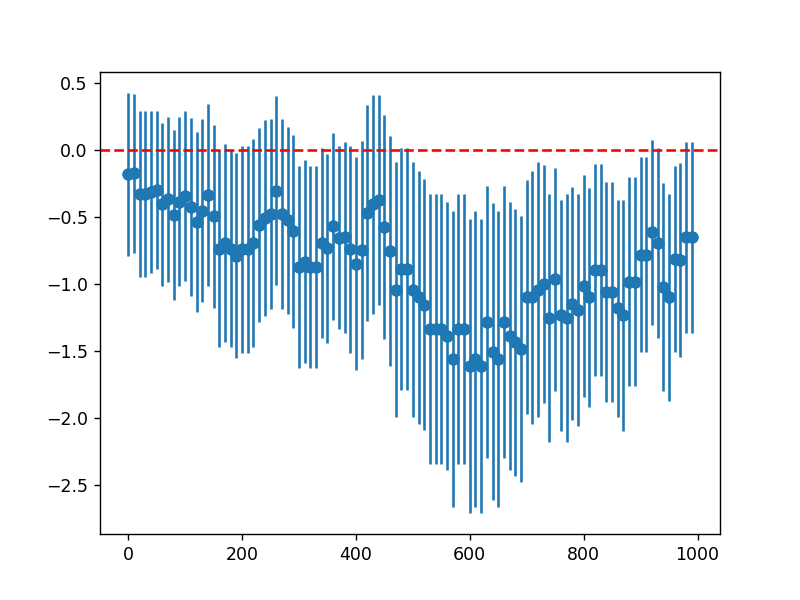

<IPython.core.display.Javascript object>


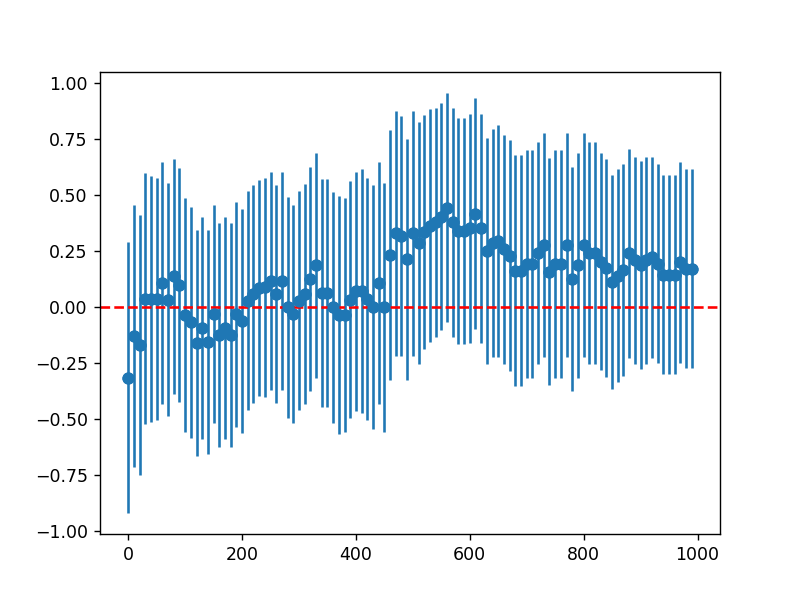

In [49]:
import statsmodels.api as sm
import pandas as pd
import lxml

# Extract estimated coeff and error from statsmodel GLM object
def coef_err(res):
    results = pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0]
    return results['coef'][0], results['std err'][0]


# Generate initial matrix for homophilous network
trait, socio_matrix = create_network(baseline_density = 0.002)
initial_choice = np.random.binomial(n = 1, p = 0.5, size = socio_matrix.shape[1])

# Initalize null matrix with density equal to homophilous network
dens = socio_matrix.mean()
null_matrix = np.random.binomial(n = 1, p = dens/2, size = sociomatrix.shape)
null_matrix = null_matrix + null_matrix.T

# Evolve networks with same initial conditions
choice_prog = evolve_network(sociomatrix, initial_choice.copy())
choice_null = evolve_network(null_matrix, initial_choice.copy())

prog_e = np.zeros((choice_prog.shape[1]//10, 2))
null_e = np.zeros((choice_prog.shape[1]//10, 2))

import warnings
warnings.filterwarnings("error")

# Estimate regression coefficient and error at every 10th time step
for k in range(choice_prog.shape[1]//10):
    try:
        res = sm.GLM(X_i, choice_prog[:,k], family=sm.families.Binomial()).fit()
        coef, err = coef_err(res)
        prog_e[k] = coef, err

        res = sm.GLM(X_i, choice_null[:,k], family=sm.families.Binomial()).fit()
        coef, err = coef_err(res)
        null_e[k] = coef, err
    except RuntimeWarning:
        print(k)

        
# %matplotlib notebook
plt.figure(0)
plt.scatter(np.arange(0, choice_prog.shape[1], 10), prog_e[:,0])
plt.errorbar(np.arange(0, choice_prog.shape[1], 10), prog_e[:,0], yerr=2*prog_e[:,1], fmt="o")
plt.axhline(y=0, color='r', linestyle='--')


# %matplotlib notebook
plt.figure(1)
plt.scatter(np.arange(0, choice_null.shape[1], 10), null_e[:,0])
plt.errorbar(np.arange(0, choice_null.shape[1], 10), null_e[:,0], yerr=2*null_e[:,1], fmt="o")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()